In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import decoupler as dc
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from itertools import combinations
import anndata
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scvi

import plotting_functions as pf

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
Global seed set to 0
/opt/apps/python/3.8.0/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
plate_palette = sns.color_palette("husl", n_colors=3)
sex_palette = ['hotpink','dodgerblue']
geno_palette = ['#DA9CC1', '#F4C245', '#C0BFBF', '#55AF5B', '#4F6EAF', '#52A5DB', '#D83026', '#683C91']


# QC plotting - 200 UMI merged adata

In [3]:
adata = sc.read("../IGVF_analysis/preprocessed_tissues/CortexHippocampuspreprocessed.h5ad")


In [4]:
adata.layers['raw_counts'] = adata.X.copy()


In [5]:
adata

AnnData object with n_obs × n_vars = 2618643 × 56953
    obs: 'bc', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'subpool', 'bc1_well', 'bc2_well', 'bc3_well', 'Mouse_Tissue_ID', 'alias_tissue1', 'alias_tissue2', 'alias_tissue3', 'alias_tissue4', 'plate', 'Protocol', 'Chemistry', 'well_type', 'Row', 'Column', 'Genotype', 'Notes', 'Multiplexed_sample1', 'Multiplexed_sample2', 'SampleType', 'Tissue', 'Tissue_ID', 'Tissue1_ontology_id', 'Tissue2_ontology_id', 'Sex', 'Replicate', 'DOB', 'Age_weeks', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Dissection_date', 'Dissection_time', 'Dissector', 'Tissue_weight_mg', 'mult_genotype_1', 'mult_genotype_2', 'mult_genotype', 'n_counts', 'doublet_scores', 'batch'
    var: 'gene_name'
    layers: 'raw_counts'

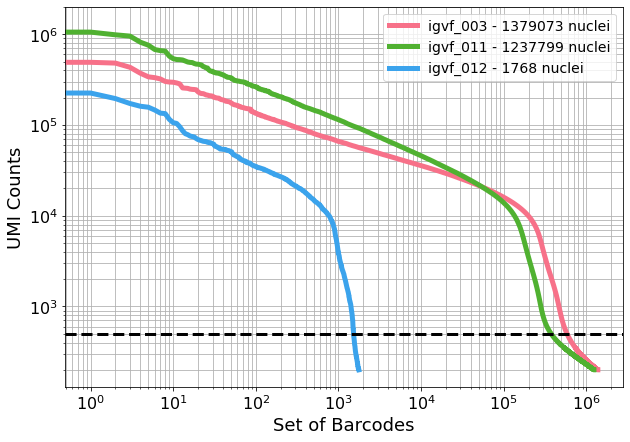

In [6]:
pf.plot_knee(adata, cutoff=500, category_column='plate', figsize=(10, 7))
plt.show()

In [7]:
# set var names to be gene names, not gene ID
adata.var_names  = adata.var['gene_name']
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


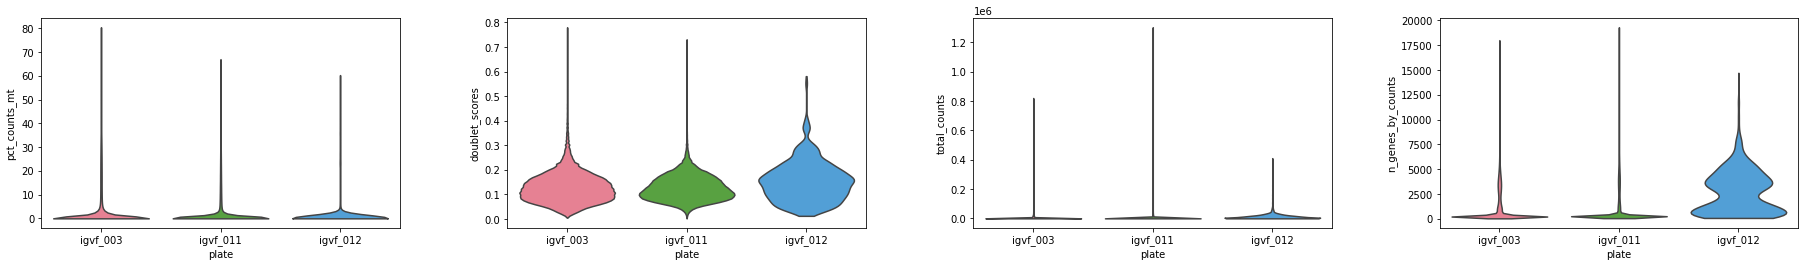

In [8]:
plate_palette = sns.color_palette("husl", n_colors=3)

sc.pl.violin(adata, ['pct_counts_mt', 'doublet_scores', 'total_counts', 'n_genes_by_counts'],
             groupby = "plate", palette = plate_palette,
             jitter=0.4, multi_panel=True, size=0)

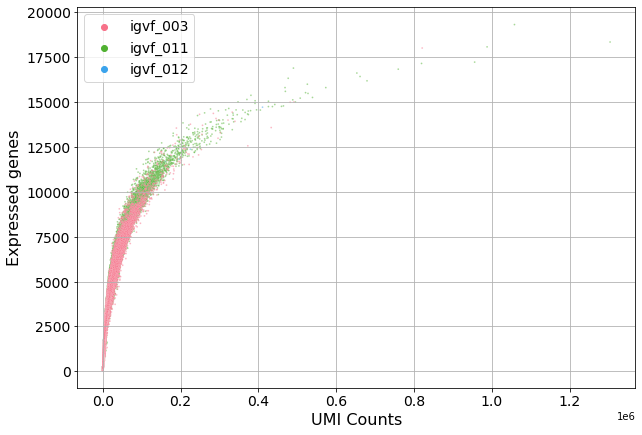

In [9]:
pf.plot_genes_by_counts(adata, category_column='plate', figsize=(10, 7))
plt.show()

In [10]:
adatas = adata[(adata.obs['total_counts'] < 10000) & (adata.obs['n_genes_by_counts'] < 2000), :]


/opt/apps/python/3.8.0/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


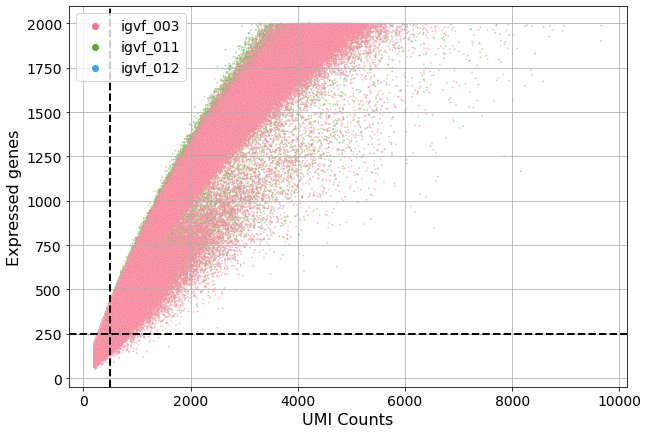

In [11]:
pf.plot_genes_by_counts(adatas, category_column='plate', figsize=(10, 7))

plt.axvline(x=500, color='k', linestyle='--', linewidth=2)
plt.axhline(y=250, color='k', linestyle='--', linewidth=2)

plt.show()

In [12]:
adatas[(adatas.obs['total_counts'] > 500) & (adatas.obs['n_genes_by_counts'] < 250), :]


View of AnnData object with n_obs × n_vars = 4147 × 56953
    obs: 'bc', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'subpool', 'bc1_well', 'bc2_well', 'bc3_well', 'Mouse_Tissue_ID', 'alias_tissue1', 'alias_tissue2', 'alias_tissue3', 'alias_tissue4', 'plate', 'Protocol', 'Chemistry', 'well_type', 'Row', 'Column', 'Genotype', 'Notes', 'Multiplexed_sample1', 'Multiplexed_sample2', 'SampleType', 'Tissue', 'Tissue_ID', 'Tissue1_ontology_id', 'Tissue2_ontology_id', 'Sex', 'Replicate', 'DOB', 'Age_weeks', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Dissection_date', 'Dissection_time', 'Dissector', 'Tissue_weight_mg', 'mult_genotype_1', 'mult_genotype_2', 'mult_genotype', 'n_counts', 'doublet_scores', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'raw_counts'

# QC plotting - filtered data
500 UMI, 250 genes, 1% mito, 0.25 doublet score


In [24]:
adata = sc.read("../IGVF_analysis/tissue_processed_500umi/CortexHippocampus_processed.h5ad")


In [25]:
print(adata.obs['Genotype'].value_counts())

adata = adata[adata.obs['Genotype'] != "tie",:]

print(adata.obs['Genotype'].value_counts())

Genotype
NODJ      115595
AJ        107974
NZOJ      102507
B6J        97478
PWKJ       87541
CASTJ      86632
129S1J     77900
WSBJ       76695
tie         8481
Name: count, dtype: int64
Genotype
NODJ      115595
AJ        107974
NZOJ      102507
B6J        97478
PWKJ       87541
CASTJ      86632
129S1J     77900
WSBJ       76695
Name: count, dtype: int64


In [5]:
adata

View of AnnData object with n_obs × n_vars = 752322 × 56953
    obs: 'bc', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'subpool', 'bc1_well', 'bc2_well', 'bc3_well', 'Mouse_Tissue_ID', 'alias_tissue1', 'alias_tissue2', 'alias_tissue3', 'alias_tissue4', 'plate', 'Protocol', 'Chemistry', 'well_type', 'Row', 'Column', 'Genotype', 'Notes', 'Multiplexed_sample1', 'Multiplexed_sample2', 'SampleType', 'Tissue', 'Tissue_ID', 'Tissue1_ontology_id', 'Tissue2_ontology_id', 'Sex', 'Replicate', 'DOB', 'Age_weeks', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Dissection_date', 'Dissection_time', 'Dissector', 'Tissue_weight_mg', 'mult_genotype_1', 'mult_genotype_2', 'mult_genotype', 'n_counts', 'doublet_scores', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'le

In [6]:
adata.var_names  = adata.var['gene_name']


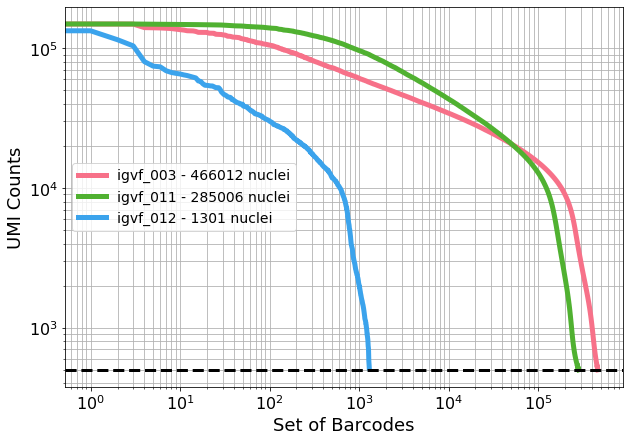

In [7]:
pf.plot_knee(adata, cutoff=500, category_column='plate', figsize=(10, 7))
plt.show()

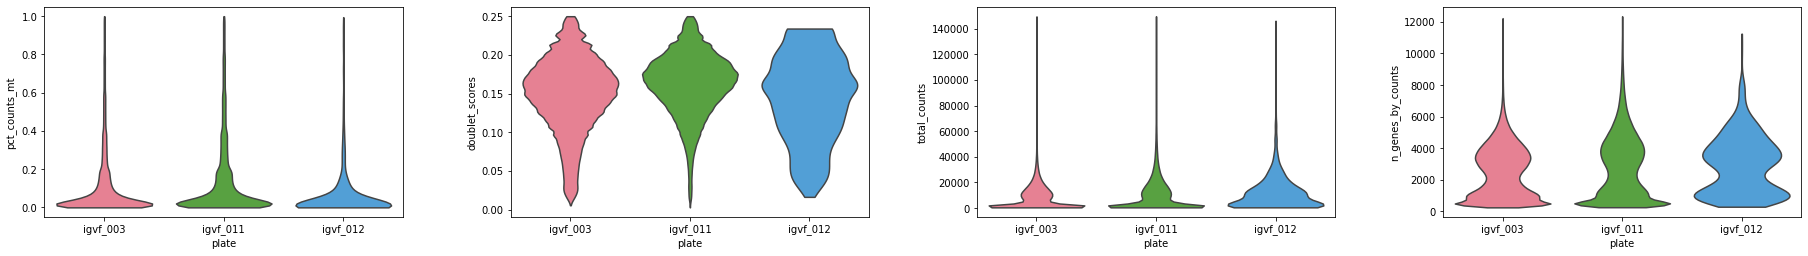

In [8]:
sc.pl.violin(adata, ['pct_counts_mt', 'doublet_scores', 'total_counts', 'n_genes_by_counts'],
             groupby = "plate", palette = plate_palette,
             jitter=0.4, multi_panel=True, size=0)

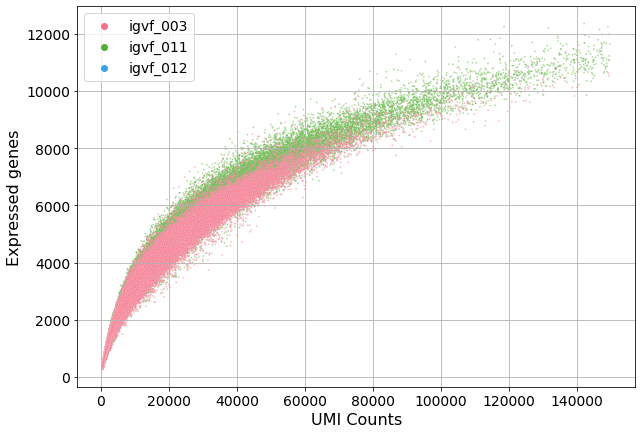

In [9]:
pf.plot_genes_by_counts(adata, category_column='plate', figsize=(10, 7))
plt.show()

# Check clustering
Plate, sex, genotype

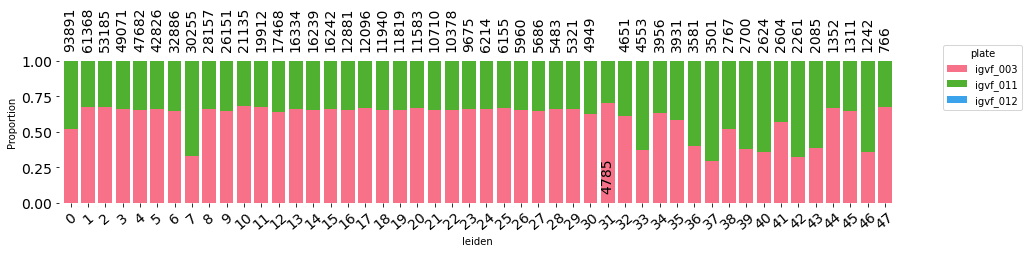

In [10]:
pf.stacked_barplot_proportions(adata.obs, 
                            'leiden', 'plate',
                            flip=False, fsize = (15,3), 
                            annotations = True)


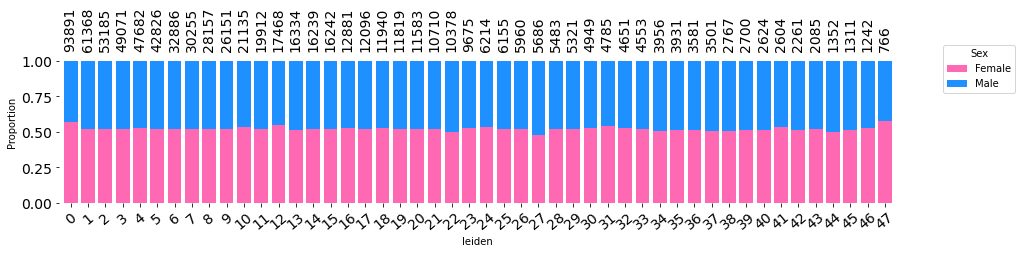

In [11]:
pf.stacked_barplot_proportions(adata.obs, 
                            'leiden', 'Sex',
                            flip=False, fsize = (15,3), 
                            annotations = True)


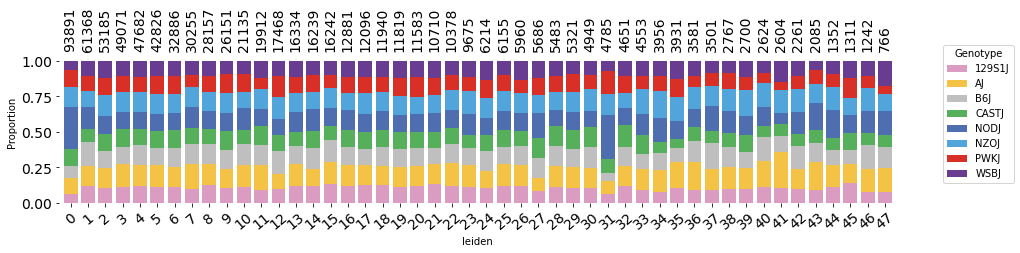

In [12]:
pf.stacked_barplot_proportions(adata.obs, 
                            'leiden', 'Genotype',
                            flip=False, fsize = (15,3), 
                            annotations = True)


/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


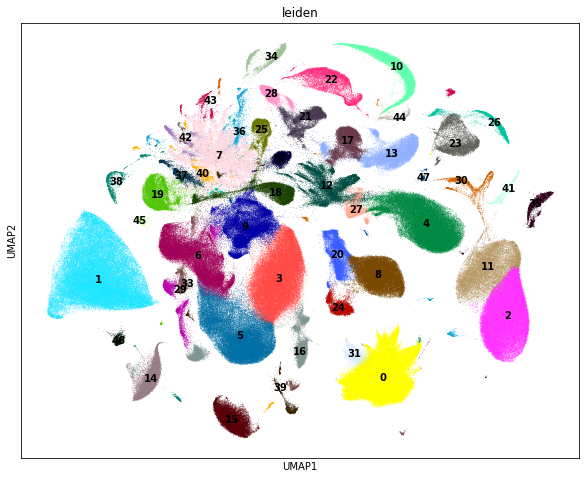

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


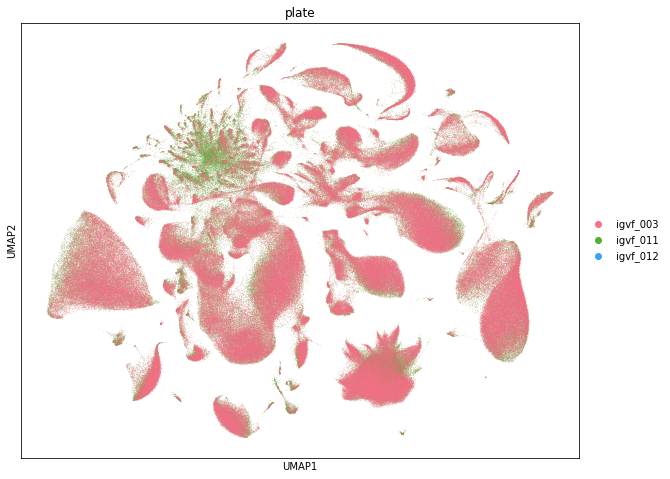

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


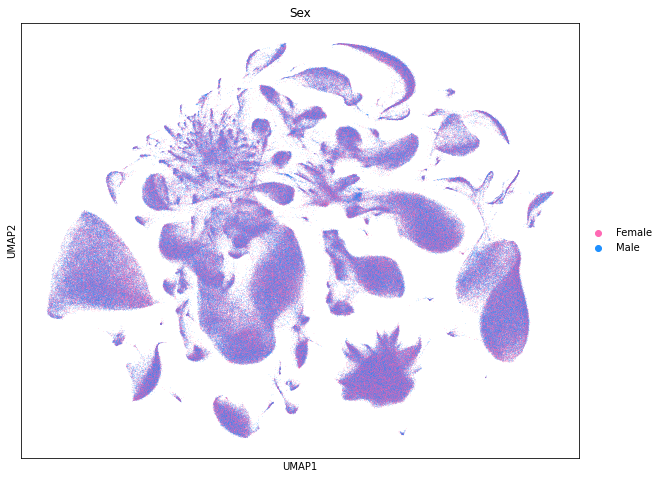

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


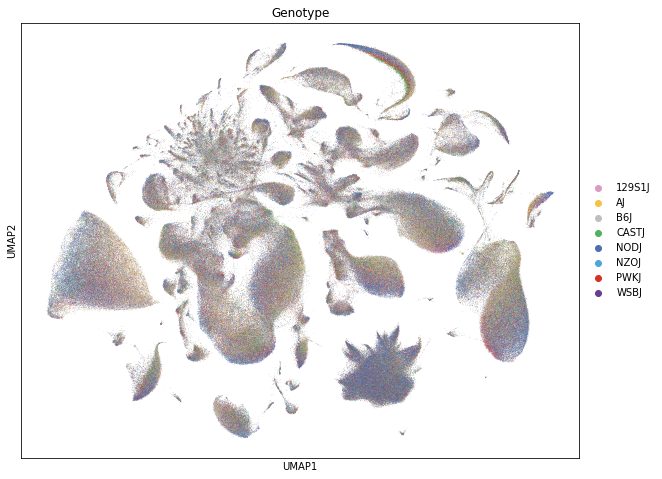

In [13]:
plt.rcParams['figure.figsize'] = (10, 8)

sc.pl.umap(adata, color=['leiden'], size=1, legend_loc = 'on data')

sc.pl.umap(adata, color=['plate'], size = 0.8, palette = plate_palette)

sc.pl.umap(adata, color=['Sex'], size = 0.8, palette = sex_palette)

sc.pl.umap(adata, color=['Genotype'], size = 0.8, palette = geno_palette)



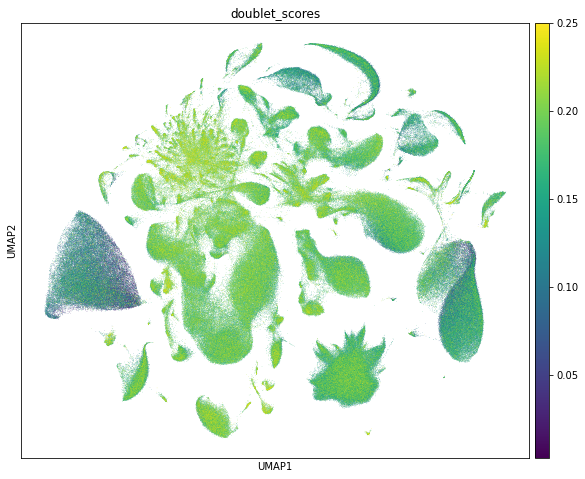

In [14]:
sc.pl.umap(adata, color=['doublet_scores'], size = 0.8)


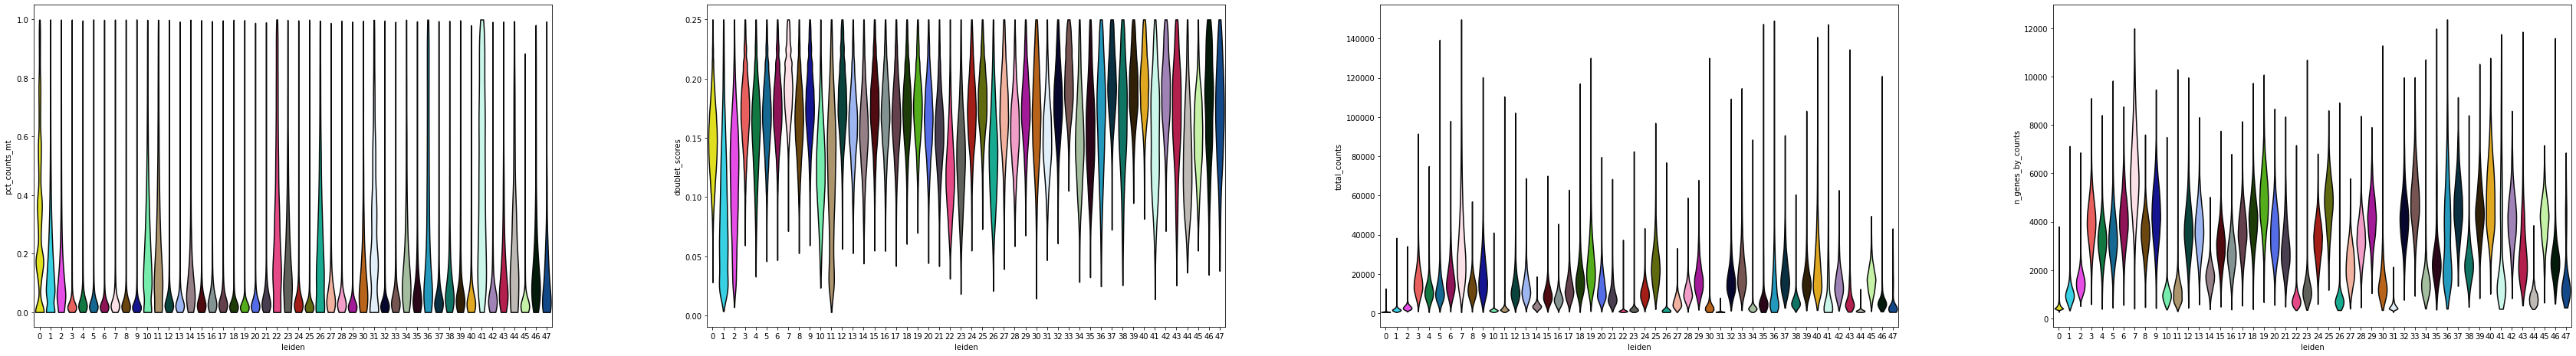

In [15]:
sc.pl.violin(adata, ['pct_counts_mt', 'doublet_scores', 'total_counts', 'n_genes_by_counts'],
             groupby = "leiden", 
             jitter=0.4, multi_panel=True, size=0)

# Check marker gene expression

In [16]:
markers_df = pd.read_csv("IGVF_curated_markers.csv")
markers_df = markers_df[markers_df['Tissue'] == 'CortexHippocampus']
marker_genes_dict = {}

for index, row in markers_df.iterrows():
    gene = row['Gene']
    subtype = row['Subtype']

    if subtype not in marker_genes_dict:
        marker_genes_dict[subtype] = [gene]
    else:
        marker_genes_dict[subtype].append(gene)

categories: 0, 1, 2, etc.
var_group_labels: Astrocyte, CA1, CA2, etc.


/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


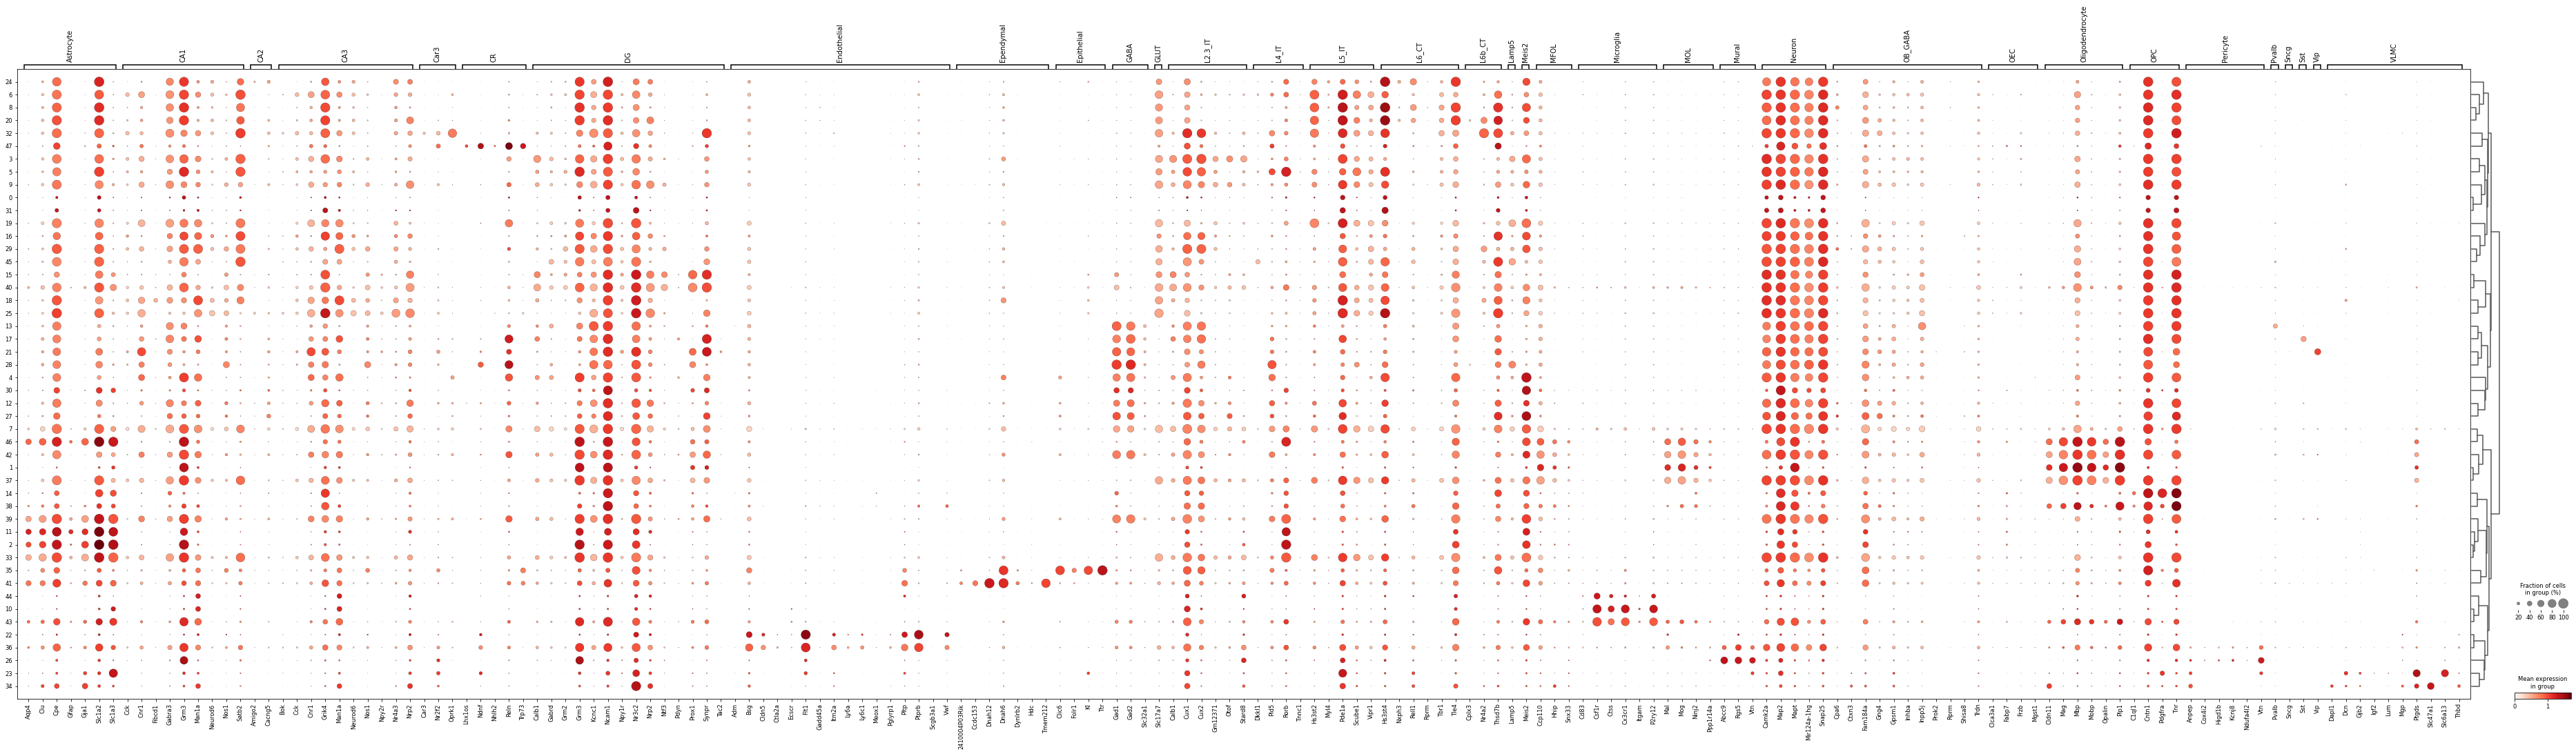

In [17]:
sc.pl.dotplot(adata, marker_genes_dict, 'leiden', mean_only_expressed = True,
              dendrogram=True, log=True)


In [18]:
smol_marker_genes_dict = {
    "Endothelial": ["Flt1"],
    "Pericyte": ["Vtn"],
    "Fibroblast": ["Bnc2","Fbxl7"],
    "VLMC": ["Dcn"],
    "Epithelial":["Kl","Ttr","Clic6"],
    "Ependymal":["Tmem212","Dnah6"],
    "Microglia": ["Cx3cr1"],
    "Astrocyte": ["Gfap","Clu"],
    "Glutamatergic": ["Slc17a7"],
    "GABAergic": ["Gad1","Gad2",],
    "CR": ["Reln"],
    "Meis2": ["Meis2"],
    "Lamp5": ["Lamp5"],
    "Vip": ["Vip"],
    "Sst": ["Sst"],
    "Pvalb": ["Pvalb"],
    "Car3": ["Car3","Oprk1"],
    "DG_early": ["Prox1"],
    "DG": ["Calb1"],
    "L2/3": ['Otof','Calb1'],
    "L4": ["Pld5"],
    "L6": ["Scube1","Hs3st2","Pde1a"],
    "OPC": ["Pdgfra"],
    "COP": ["C1ql1"],
    "MFOL": ["Mag","Mog"],
    "MOL": ["Plp1"],
    "Heart": ["Ryr1","Gata4"],
    "Gastrocnemius": ["Myh4","Ttn"]
}



categories: 0, 1, 2, etc.
var_group_labels: Endothelial, Pericyte, Fibroblast, etc.


/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


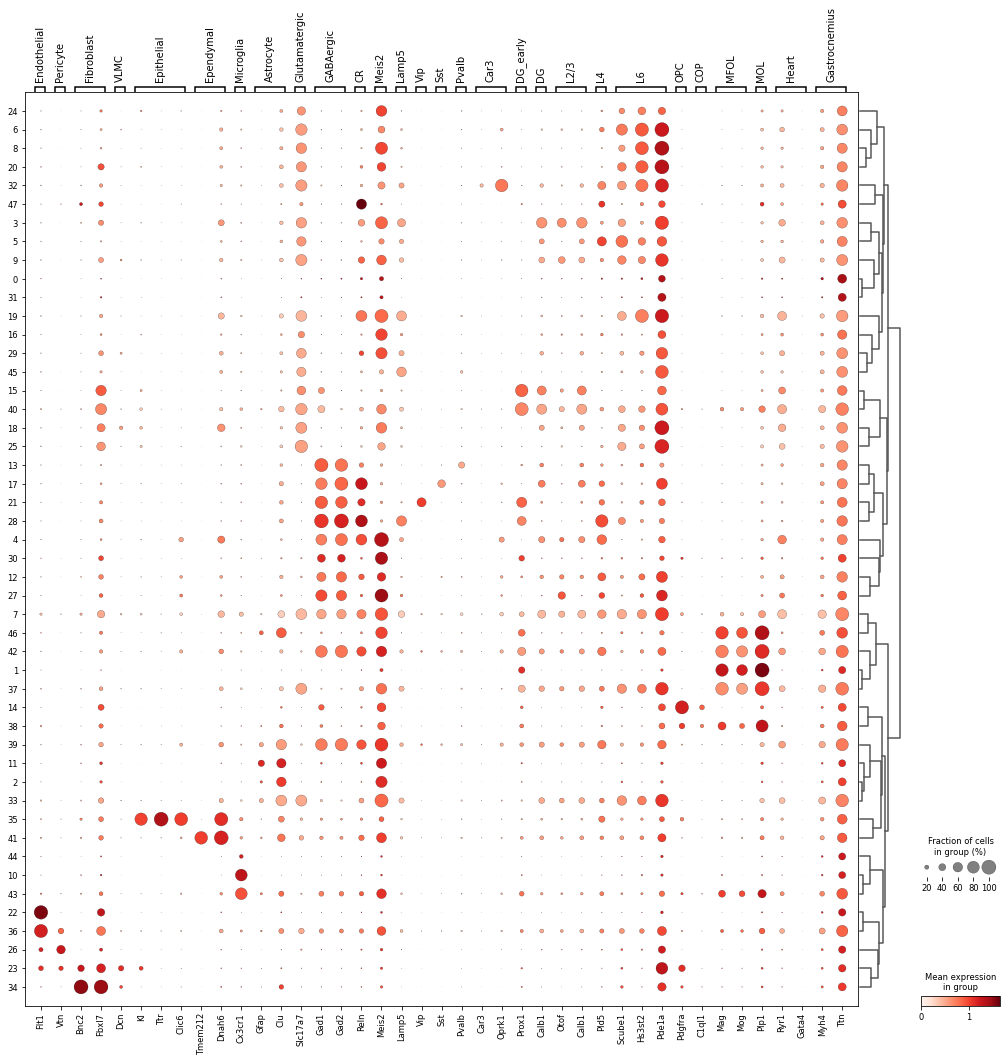

In [19]:
sc.pl.dotplot(adata, smol_marker_genes_dict, 'leiden', mean_only_expressed = True,
              dendrogram=True, log=True)


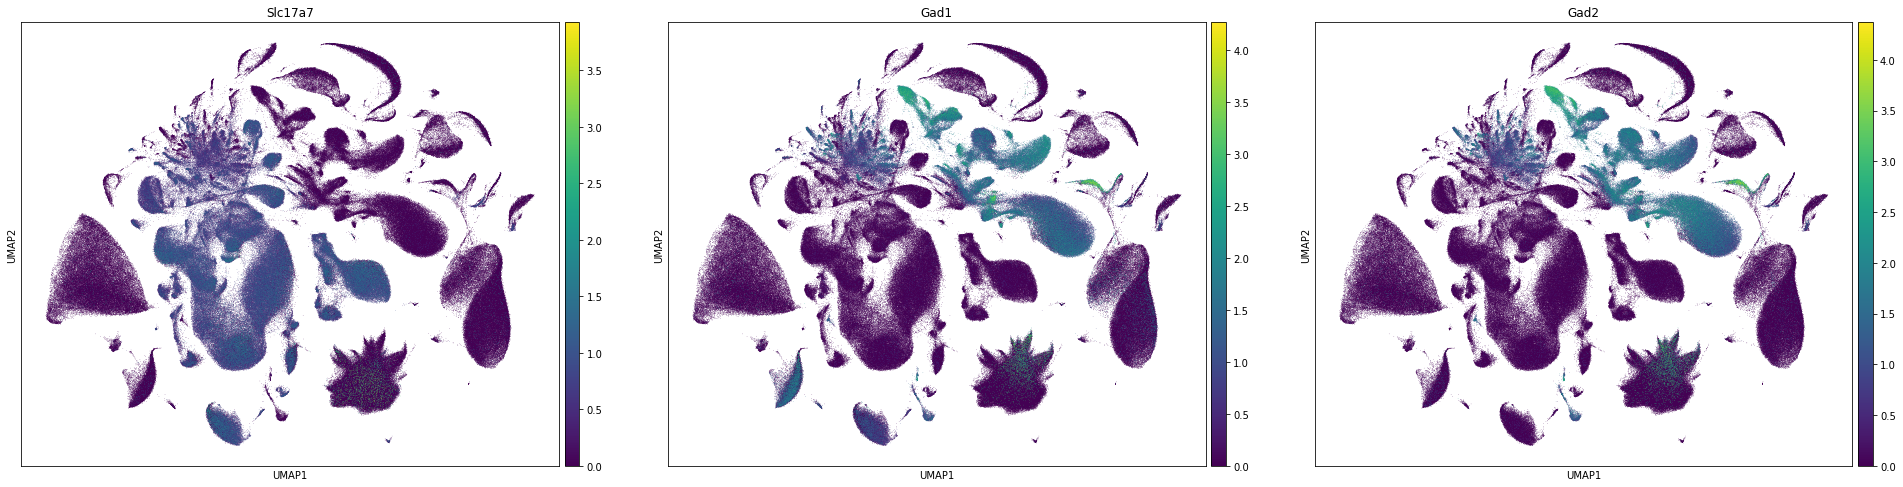

In [20]:
plt.rcParams['figure.figsize'] = (10, 8)

sc.pl.umap(adata, color=['Slc17a7','Gad1','Gad2'], size=1)



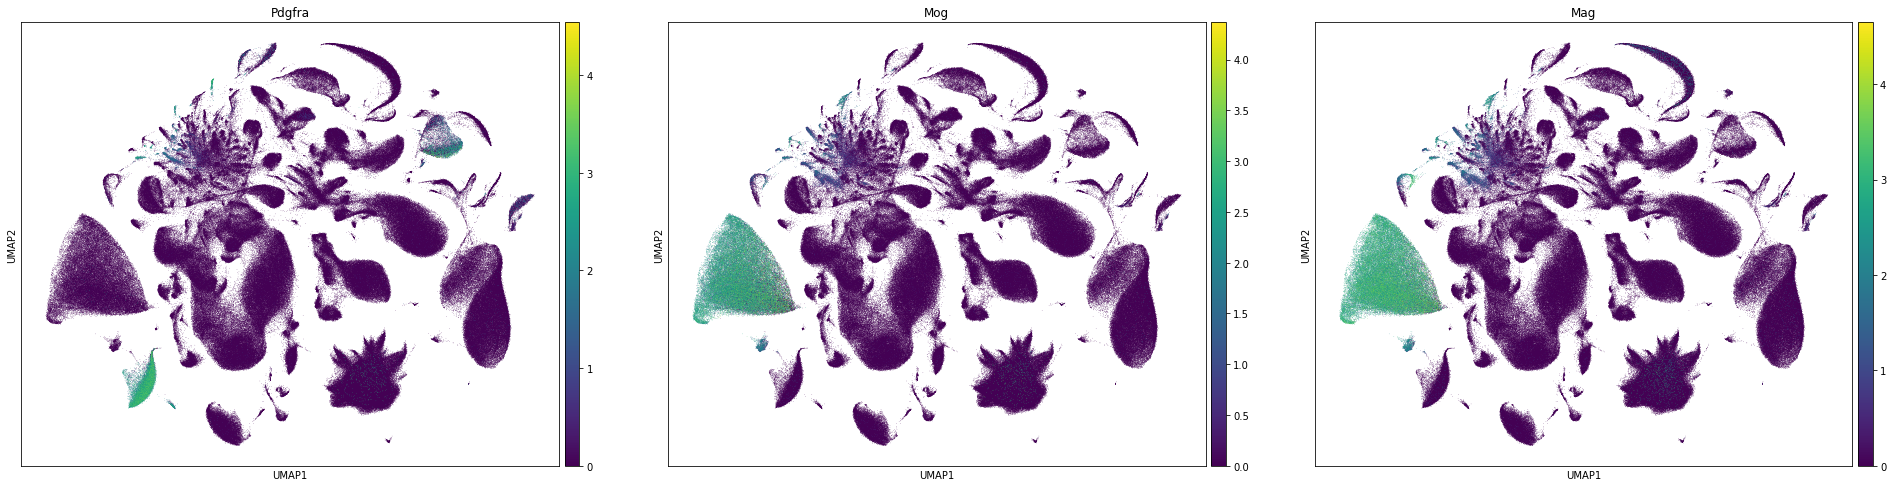

In [21]:
sc.pl.umap(adata, color=['Pdgfra','Mog','Mag'], size=1)

# Label transfer from ENC4 Parse 2mo data
Combine cortex and hippocampus 

## Prepare reference

In [ ]:
ctx_data = sc.read_mtx("/dfs5/bio/erebboah/snrna/cortex/seurat/cortex_all_genes.mtx")
  
ctx_obs = pd.read_csv("/dfs5/bio/erebboah/snrna/cortex/seurat/cortex_Parse_10x_integrated_metadata.csv")
ctx_obs = ctx_obs[['cellID', 'tissue', 'technology','timepoint','celltypes', 'subtypes']]

ctx_var = pd.read_csv("/dfs5/bio/erebboah/snrna/cortex/seurat/cortex_seurat_genes.csv", index_col = 0)
ctx_var.columns = ["gene_name"]

X = ctx_data.X
X = X.T
ctx_ref = anndata.AnnData(X=X, obs=ctx_obs, var=ctx_var)
ctx_ref.obs.index = ctx_obs["cellID"]
ctx_ref.var_names  = ctx_ref.var['gene_name']


In [ ]:
hc_data = sc.read_mtx("/dfs5/bio/erebboah/snrna/hippocampus/seurat/hippocampus_all_genes.mtx")
  
hc_obs = pd.read_csv("/dfs5/bio/erebboah/snrna/hippocampus/seurat/hippocampus_Parse_10x_integrated_metadata.csv")
hc_obs = hc_obs[['cellID', 'tissue', 'technology','timepoint','celltypes', 'subtypes']]

hc_var = pd.read_csv("/dfs5/bio/erebboah/snrna/hippocampus/seurat/hippocampus_seurat_genes.csv", index_col = 0)
hc_var.columns = ["gene_name"]

X = hc_data.X
X = X.T
hc_ref = anndata.AnnData(X=X, obs=hc_obs, var=hc_var)
hc_ref.obs.index = hc_obs["cellID"]
hc_ref.var_names  = hc_ref.var['gene_name']


In [ ]:
ref_data = anndata.concat([ctx_ref,hc_ref], merge = "same")

In [ ]:
ref_data = ref_data[ref_data.obs['technology'] == "Parse",:]
ref_data = ref_data[ref_data.obs['timepoint'] == "PNM_02",:]


In [ ]:
ref_data.layers["raw_counts"] = ref_data.X.copy()


In [ ]:
ref_data.write_h5ad("../IGVF_analysis/external_ref/enc4_parse_pnm02_cortexhippocampus.h5ad")
                    
                    

## Merge and preprocess

In [ ]:
ref_data = sc.read("../IGVF_analysis/external_ref/enc4_parse_pnm02_cortexhippocampus.h5ad")


In [ ]:
adata.var_names  = adata.var['gene_name']


In [ ]:
adata.obs['batch'] = 'query'
ref_data.obs['batch'] = 'reference'

In [ ]:
adata = adata.concatenate(ref_data)


In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata


In [ ]:
sc.pp.highly_variable_genes(adata, flavor = 'seurat_v3', n_top_genes=2000,
                            layer = "raw_counts", batch_key="batch", subset = True)



# Run scvi

In [ ]:
scvi.model.SCVI.setup_anndata(adata, layer = 'raw_counts', batch_key='batch')
vae = scvi.model.SCVI(adata)
vae.train()


In [ ]:
adata.obs['subtypes'] = adata.obs['subtypes'].cat.add_categories('Unknown')
adata.obs = adata.obs.fillna(value = {'subtypes': 'Unknown'})



In [ ]:
lvae = scvi.model.SCANVI.from_scvi_model(vae, adata = adata, unlabeled_category = 'Unknown',
                                        labels_key = 'subtypes')

lvae.train(max_epochs=20, n_samples_per_label=100)

adata.obs['predictions'] = lvae.predict(adata)


In [ ]:
adata.obs['cell_barcodes'] = adata.obs.index.map(lambda x: x[:-2])

cell_mapper = dict(zip(adata.obs.cell_barcodes, adata.obs.predictions))

## Map back onto original adata

In [ ]:
adata = sc.read("../IGVF_analysis/tissue_processed_500umi/CortexHippocampus_processed.h5ad")
adata = adata[adata.obs['Genotype'] != "tie",:]


In [ ]:
adata.obs['predictions'] = adata.obs.index.map(cell_mapper)


In [ ]:
adata.write_h5ad('../IGVF_analysis/annotated_tissues/CortexHippocampus_filtered.h5ad')


In [3]:
adata = sc.read("../IGVF_analysis/annotated_tissues/CortexHippocampus_filtered.h5ad")


In [8]:
adata.var_names  = adata.var['gene_name']


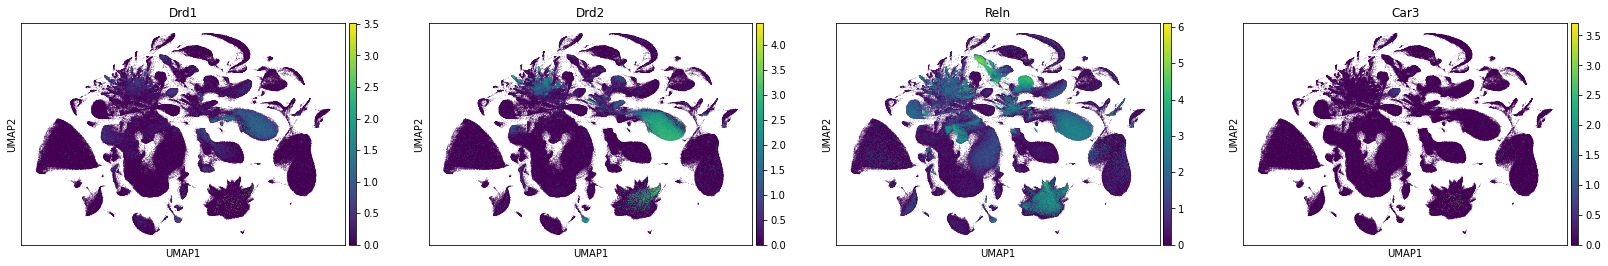

In [12]:
sc.pl.umap(adata, color=['Drd1','Drd2','Reln','Car3'], size=1)


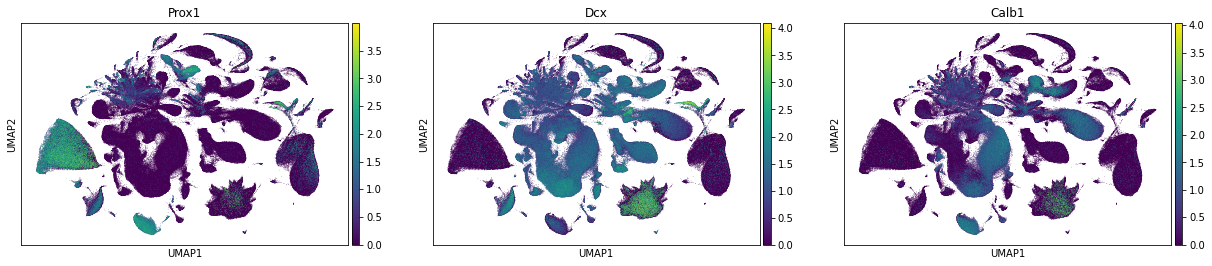

In [15]:
sc.pl.umap(adata, color=['Prox1','Dcx','Calb1'], size=1)


/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


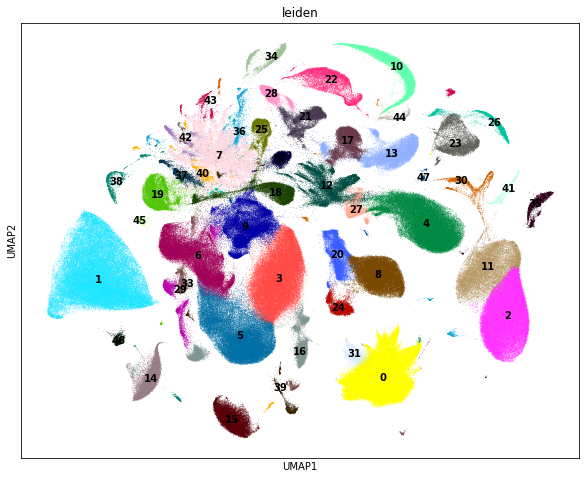

In [13]:
sc.pl.umap(adata, color=['leiden'], size=1, legend_loc = 'on data')


/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


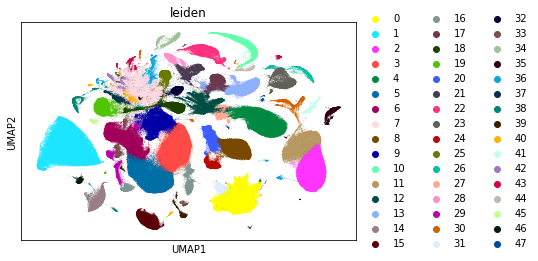

In [11]:
sc.pl.umap(adata, color=['leiden'], size=1)


/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


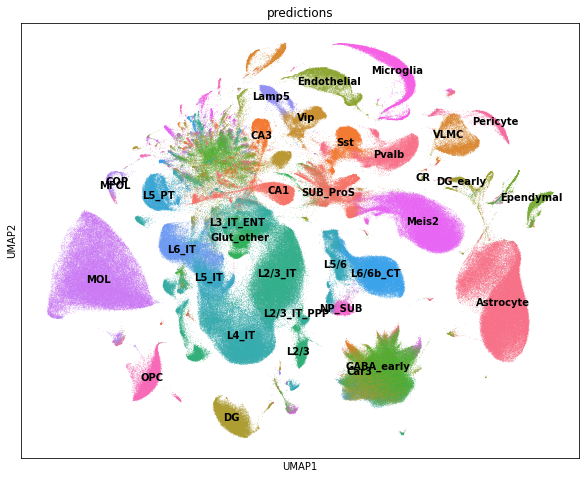

In [11]:
color_palette = sns.color_palette("husl", n_colors=30)

plt.rcParams['figure.figsize'] = (10, 8)


sc.pl.umap(adata, color=['predictions'], size=1, legend_loc = 'on data',palette=color_palette)



/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


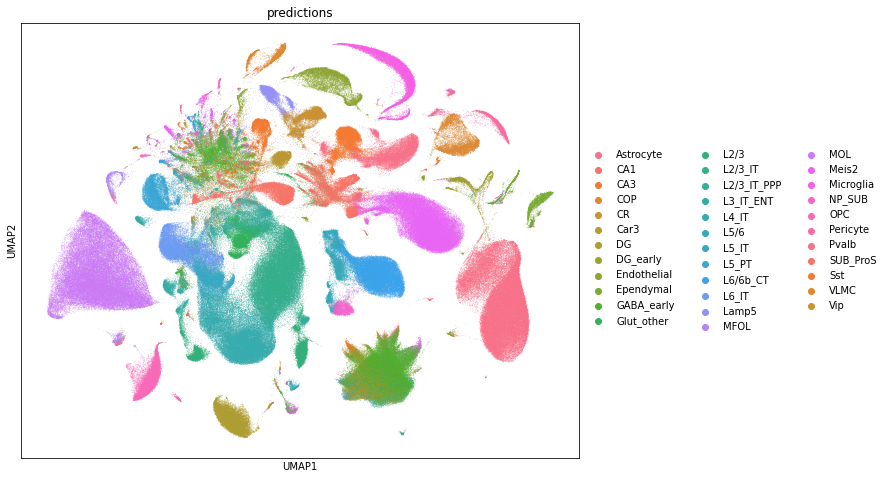

In [12]:
sc.pl.umap(adata, color=['predictions'], size=1, palette=color_palette)


In [7]:
obs = adata.obs

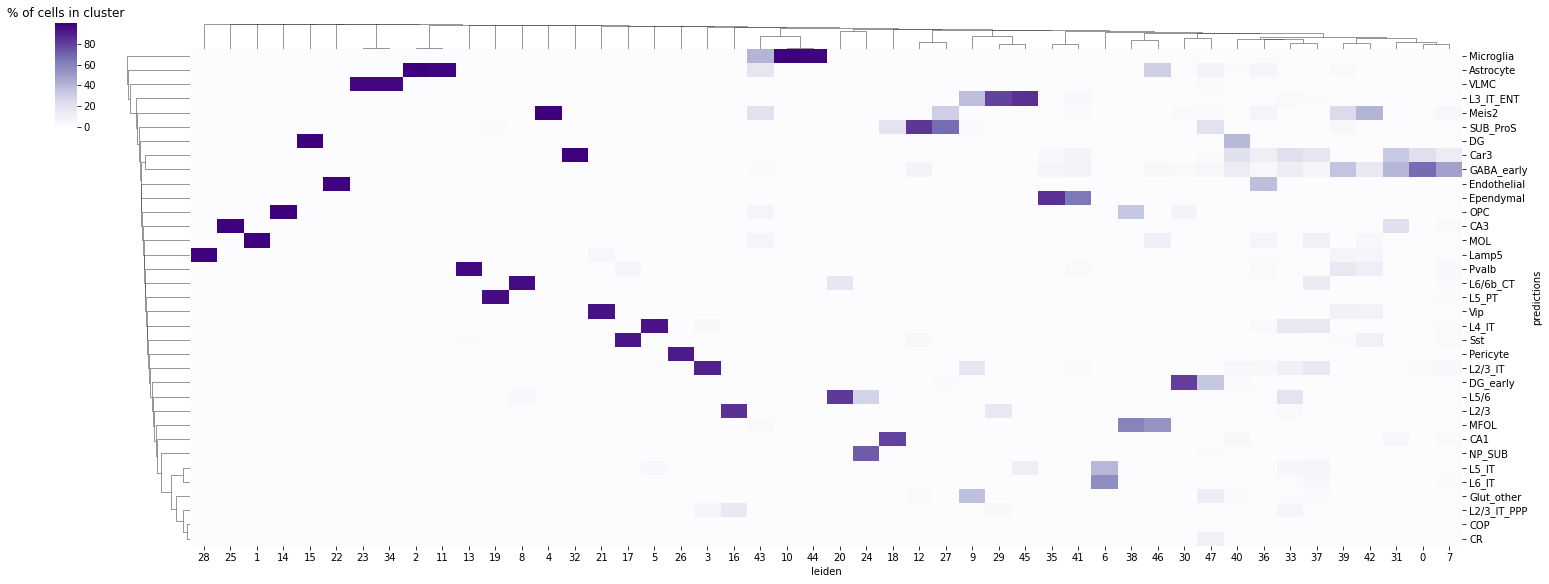

In [8]:
confusion_matrix_df = pd.crosstab(obs['leiden'], obs['predictions'])
confusion_matrix_df_percentage = confusion_matrix_df.div(confusion_matrix_df.sum(axis=1), axis=0) * 100
confusion_matrix_df_percentage_transposed = confusion_matrix_df_percentage.transpose()

sns.clustermap(confusion_matrix_df_percentage_transposed, 
               cmap='Purples',
               dendrogram_ratio=0.05,
               cbar_pos=(-0.04, 0.8, 0.015, 0.18),
               cbar=True,
               method='average', 
               metric='euclidean', 
               figsize=(20, 8), 
               col_cluster=True, 
               row_cluster=True)
plt.title('% of cells in cluster')
plt.show()

# Assign celltypes to clusters

In [12]:
annots = pd.read_csv("CortexHippocampus_annotations.csv")
annots['leiden'] = annots['leiden'].astype(str)

annotation_dict = annots.groupby('leiden').head(1).set_index('leiden')['general_celltype'].to_dict()
adata.obs['general_celltype'] = adata.obs['leiden'].map(annotation_dict)
annotation_dict = annots.groupby('leiden').head(1).set_index('leiden')['general_CL_ID'].to_dict()
adata.obs['general_CL_ID'] = adata.obs['leiden'].map(annotation_dict)

annotation_dict = annots.groupby('leiden').head(1).set_index('leiden')['celltype'].to_dict()
adata.obs['celltype'] = adata.obs['leiden'].map(annotation_dict)
annotation_dict = annots.groupby('leiden').head(1).set_index('leiden')['CL_ID'].to_dict()
adata.obs['CL_ID'] = adata.obs['leiden'].map(annotation_dict)

annotation_dict = annots.groupby('leiden').head(1).set_index('leiden')['subtype'].to_dict()
adata.obs['subtype'] = adata.obs['leiden'].map(annotation_dict)



/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


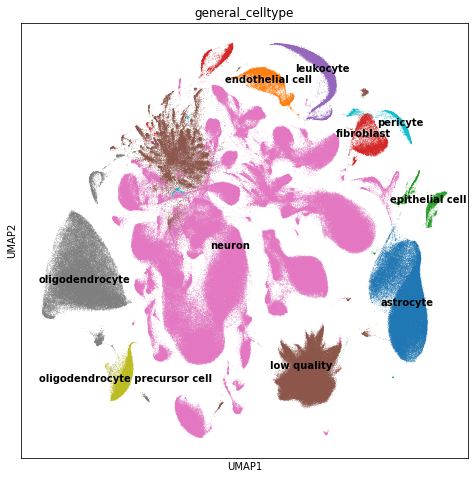

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


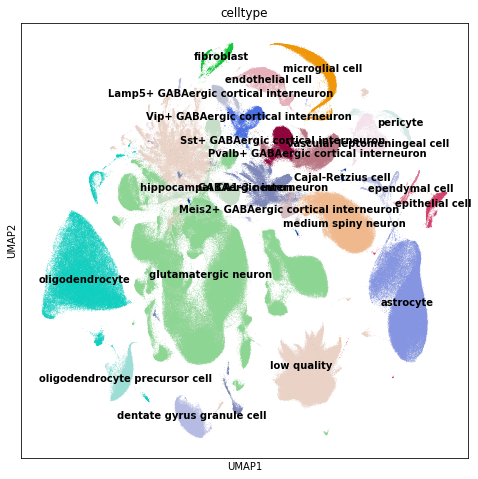

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


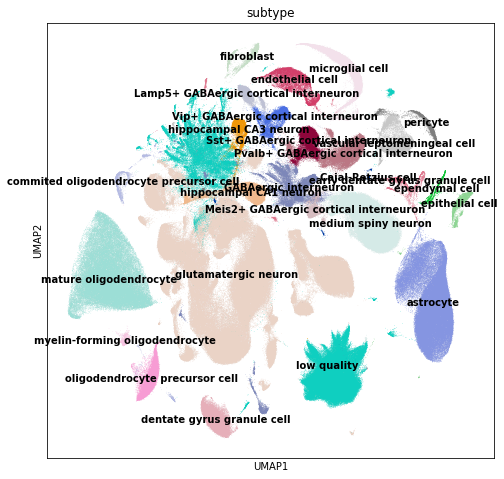

In [13]:
plt.rcParams['figure.figsize'] = (8, 8)

sc.pl.umap(adata, color=['general_celltype'], size=1, legend_loc = 'on data')
sc.pl.umap(adata, color=['celltype'], size=1, legend_loc = 'on data')
sc.pl.umap(adata, color=['subtype'], size=1, legend_loc = 'on data')


/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


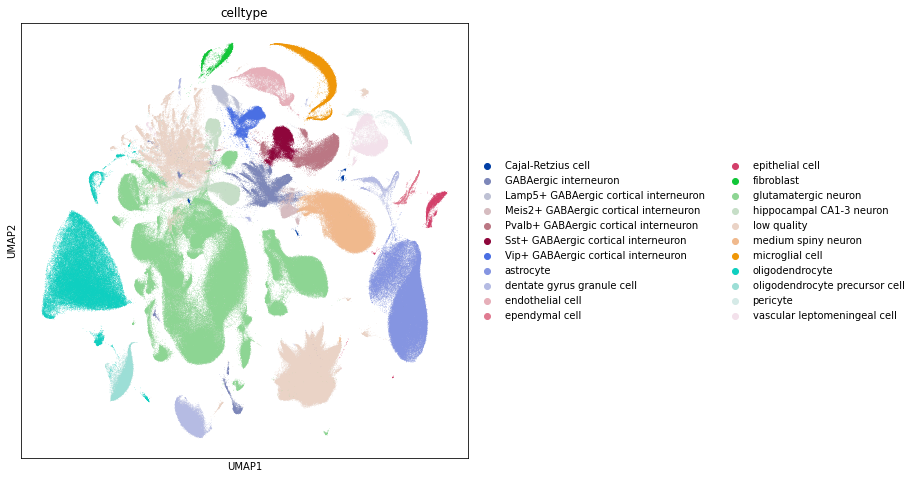

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


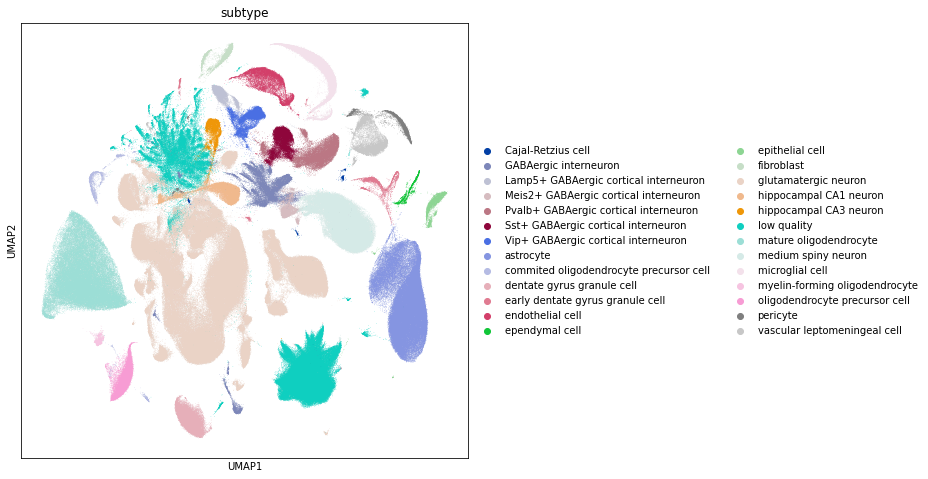

In [14]:
sc.pl.umap(adata, color=['celltype'], size=1)
sc.pl.umap(adata, color=['subtype'], size=1)


categories: Cajal-Retzius cell, GABAergic interneuron, Lamp5+ GABAergic cortical interneuron, etc.
var_group_labels: Endothelial, Pericyte, Fibroblast, etc.


/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


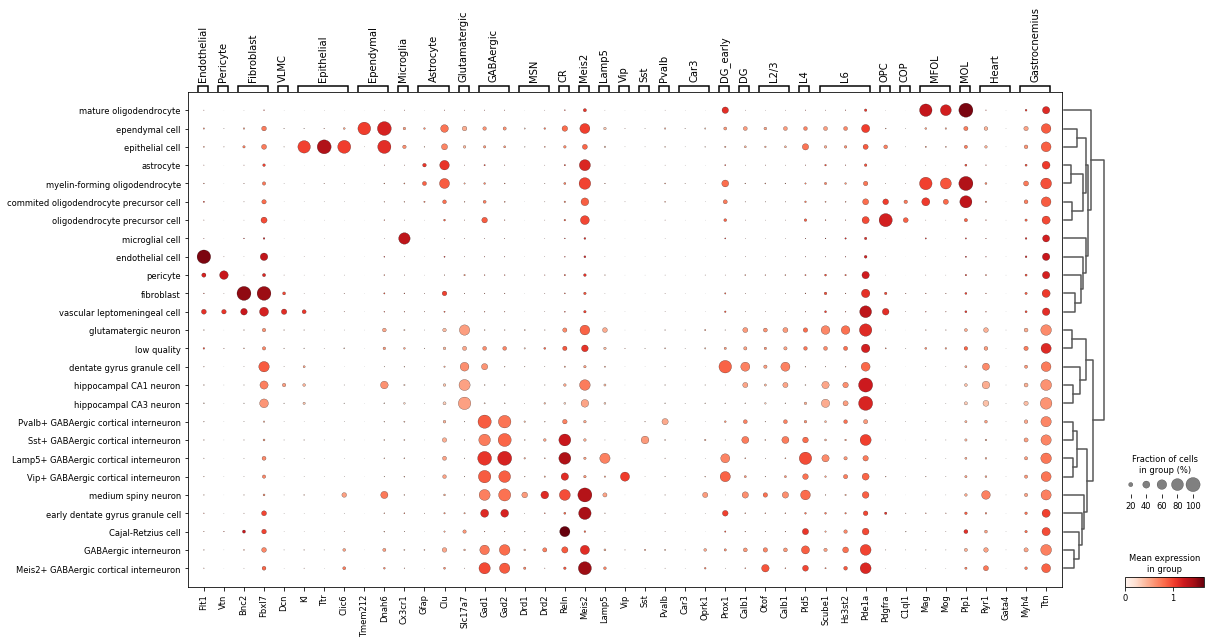

In [16]:
smol_marker_genes_dict = {
    "Endothelial": ["Flt1"],
    "Pericyte": ["Vtn"],
    "Fibroblast": ["Bnc2","Fbxl7"],
    "VLMC": ["Dcn"],
    "Epithelial":["Kl","Ttr","Clic6"],
    "Ependymal":["Tmem212","Dnah6"],
    "Microglia": ["Cx3cr1"],
    "Astrocyte": ["Gfap","Clu"],
    "Glutamatergic": ["Slc17a7"],
    "GABAergic": ["Gad1","Gad2",],
    "MSN": ["Drd1","Drd2",],
    "CR": ["Reln"],
    "Meis2": ["Meis2"],
    "Lamp5": ["Lamp5"],
    "Vip": ["Vip"],
    "Sst": ["Sst"],
    "Pvalb": ["Pvalb"],
    "Car3": ["Car3","Oprk1"],
    "DG_early": ["Prox1"],
    "DG": ["Calb1"],
    "L2/3": ['Otof','Calb1'],
    "L4": ["Pld5"],
    "L6": ["Scube1","Hs3st2","Pde1a"],
    "OPC": ["Pdgfra"],
    "COP": ["C1ql1"],
    "MFOL": ["Mag","Mog"],
    "MOL": ["Plp1"],
    "Heart": ["Ryr1","Gata4"],
    "Gastrocnemius": ["Myh4","Ttn"]
}


adata.var_names  = adata.var['gene_name']

sc.pl.dotplot(adata, smol_marker_genes_dict, 'subtype', mean_only_expressed = True,
              dendrogram=True, log=True)


# Save annotated adata

In [18]:
adata.write_h5ad('../IGVF_analysis/annotated_tissues/CortexHippocampus_annotated.h5ad')


In [17]:
meta = adata.obs
meta.to_csv(f"../IGVF_analysis/annotated_tissues/CortexHippocampus_annotated_metadata.csv")

# Pseudobulk PCA

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import decoupler as dc
import anndata
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
tissue = "CortexHippocampus"

In [2]:
adata = sc.read(f"../IGVF_analysis/annotated_tissues/{tissue}_annotated.h5ad")
adata = adata[~adata.obs['celltype'].isin(["low quality"])]
adata = adata[(adata.obs['Genotype'] != "tie")]


In [3]:
adata.obs['Mouse_Tissue_ID'] = adata.obs['Mouse_Tissue_ID'].astype(str)


/tmp/ipykernel_3422371/2200752215.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Mouse_Tissue_ID'] = adata.obs['Mouse_Tissue_ID'].astype(str)


In [5]:
# adjust mouse_tissue_id
ms1 = ['B6J','AJ','WSBJ','129S1J']
ms2 = ['NODJ','PWKJ','NZOJ','CASTJ']

# Define a function to update 'Mouse_Tissue_ID' based on conditions
def update_mouse_tissue_id(row):
    if row['plate'] != 'igvf_012' and row['Column'] in [9, 10, 11, 12]:
        if row['Genotype'] in ms1:
            return row['Multiplexed_sample1']
        elif row['Genotype'] in ms2:
            return row['Multiplexed_sample2']
    return row['Mouse_Tissue_ID']

meta = adata.obs

# Apply the function to update the 'Mouse_Tissue_ID' column
meta['Mouse_Tissue_ID'] = meta.apply(update_mouse_tissue_id, axis=1)
adata.obs['Mouse_Tissue_ID'] = meta['Mouse_Tissue_ID']


In [18]:
import decoupler as dc

pdata = dc.get_pseudobulk(
    adata,
    sample_col='Mouse_Tissue_ID',
    groups_col=None,
    obs=adata.obs,
    layer='raw_counts',
    mode='sum',
    min_cells=10,
    min_counts=10000
)



In [19]:
for c in pdata.obs.columns:
        if pd.api.types.is_object_dtype(pdata.obs[c].dtype):
            pdata.obs[c] = pdata.obs[c].fillna('NA')

In [20]:
pdata

AnnData object with n_obs × n_vars = 65 × 49172
    obs: 'Mouse_Tissue_ID', 'Protocol', 'Chemistry', 'Genotype', 'Notes', 'SampleType', 'Tissue', 'Tissue_ID', 'Tissue1_ontology_id', 'Tissue2_ontology_id', 'Sex', 'Replicate', 'Age_weeks', 'psbulk_n_cells', 'psbulk_counts'
    var: 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'psbulk_props'

In [21]:
pdata.write_h5ad(f'../IGVF_analysis/pseudobulk/{tissue}_pseudobulk_raw.h5ad')

In [4]:
pdata = sc.read(f'../IGVF_analysis/pseudobulk/{tissue}_pseudobulk_raw.h5ad')

In [5]:
sc.pp.normalize_total(pdata, target_sum=1e4) # Counts per 10k
sc.pp.log1p(pdata)

sc.tl.pca(pdata, svd_solver='arpack', use_highly_variable = False)



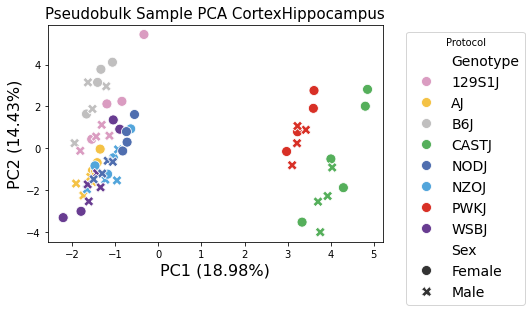

In [6]:
df = pd.DataFrame(pdata.obsm["X_pca"])
meta  = pdata.obs
df.set_index(meta['Mouse_Tissue_ID'], inplace=True)
merged_df = pd.merge(df, meta, left_index=True, right_on='Mouse_Tissue_ID')


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

geno_palette = ['#DA9CC1', '#F4C245', '#C0BFBF', '#55AF5B', '#4F6EAF', '#52A5DB', '#D83026', '#683C91']


sns.scatterplot(x=merged_df.iloc[:, 0], y=merged_df.iloc[:, 1], 
                hue=merged_df['Genotype'], 
                style=merged_df['Sex'], 
                s=100, 
                palette=geno_palette,
                alpha=1)  # Adjust transparency if needed

plt.xlabel("PC1", fontsize=16)
plt.ylabel("PC2", fontsize=16)
plt.title(f'Pseudobulk Sample PCA {tissue}', fontsize=15)

plt.legend(title='Protocol', fontsize=14, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(False)
pc1 = pdata.uns["pca"]["variance_ratio"][0]
pc2 = pdata.uns["pca"]["variance_ratio"][1]
plt.xlabel(f"PC1 ({pc1:.2%})", fontsize=16)
plt.ylabel(f"PC2 ({pc2:.2%})", fontsize=16)


plt.show()


# Pseudobulk subtype expression

In [ ]:
import scanpy as sc
import decoupler as dc
import pandas as pd


In [ ]:
tissue = "CortexHippocampus"
adata = sc.read(f"../IGVF_analysis/tissue_processed_500umi/{tissue}_processed.h5ad")


In [ ]:
meta = pd.read_csv(f"../IGVF_analysis/annotated_tissues/{tissue}_annotated_metadata.csv")
cell_mapper = dict(zip(meta['cellID'], meta['subtype']))

adata.obs['subtype'] = adata.obs.index.map(cell_mapper)
mask = ~adata.obs['subtype'].isna()
adata = adata[mask]


In [ ]:
pdata = dc.get_pseudobulk(
    adata,
    sample_col="subtype",
    groups_col=None,
    obs=adata.obs,
    layer='raw_counts',
    mode='sum',
    min_cells=10,
    min_counts=10000
)

for c in pdata.obs.columns:
        if pd.api.types.is_object_dtype(pdata.obs[c].dtype):
            pdata.obs[c] = pdata.obs[c].fillna('NA')
            
pdata.write_h5ad(f'../IGVF_analysis/pseudobulk/{tissue}_pseudobulk_subtype_sum.h5ad')


In [ ]:
pdata = dc.get_pseudobulk(
    adata,
    sample_col="subtype",
    groups_col=None,
    obs=adata.obs,
    layer='raw_counts',
    mode='median',
    min_cells=10,
    min_counts=10000
)

for c in pdata.obs.columns:
        if pd.api.types.is_object_dtype(pdata.obs[c].dtype):
            pdata.obs[c] = pdata.obs[c].fillna('NA')
            
pdata.write_h5ad(f'../IGVF_analysis/pseudobulk/{tissue}_pseudobulk_subtype_median.h5ad')


In [ ]:
pdata = dc.get_pseudobulk(
    adata,
    sample_col="subtype",
    groups_col=None,
    obs=adata.obs,
    layer='raw_counts',
    mode='mean',
    min_cells=10,
    min_counts=10000
)

for c in pdata.obs.columns:
        if pd.api.types.is_object_dtype(pdata.obs[c].dtype):
            pdata.obs[c] = pdata.obs[c].fillna('NA')
            

pdata.write_h5ad(f'../IGVF_analysis/pseudobulk/{tissue}_pseudobulk_subtype_mean.h5ad')


# check

In [2]:
adata = sc.read_h5ad('../IGVF_analysis/annotated_tissues/CortexHippocampus_annotated.h5ad')



In [3]:
meta = adata.obs
meta['cellID'] = meta.index


In [4]:

meta = meta[['cellID','Genotype','Multiplexed_sample1','Multiplexed_sample2','well_type']]


In [5]:
meta.reset_index(drop=True, inplace=True)


In [16]:
meta.head()

cellID Genotype Multiplexed_sample1 Multiplexed_sample2  \
0   C3_A1_A2_13F_igvf_012     NZOJ                  NA                  NA   
1   C2_A5_A2_13F_igvf_012     NZOJ                  NA                  NA   
2  C2_C11_A2_13F_igvf_012     NZOJ                  NA                  NA   
3   C4_D1_A2_13F_igvf_012     NZOJ                  NA                  NA   
4   C3_A9_A2_13F_igvf_012     NZOJ                  NA                  NA   

  well_type  
0    Single  
1    Single  
2    Single  
3    Single  
4    Single

In [17]:
geno_counts = pd.read_csv("/share/crsp/lab/seyedam/share/igvf_pipeline/klue/igvf_011/Sublibrary_2/genotype_counts.tsv", sep = "\t")


In [18]:
merged_df = pd.merge(meta, geno_counts, on='cellID')


In [20]:
merged_df2 = merged_df[merged_df['well_type'] == "Multiplexed"]

In [21]:
merged_df

cellID Genotype Multiplexed_sample1  \
0       D12_B7_A2_Sublibrary_2_igvf_011       AJ       035_AJ_10M_03   
1      D12_B11_A2_Sublibrary_2_igvf_011     PWKJ       035_AJ_10M_03   
2       D12_D9_A2_Sublibrary_2_igvf_011     PWKJ       035_AJ_10M_03   
3      D12_F10_B1_Sublibrary_2_igvf_011       AJ       035_AJ_10M_03   
4      D12_F11_B1_Sublibrary_2_igvf_011       AJ       035_AJ_10M_03   
...                                 ...      ...                 ...   
18599  B12_F11_F7_Sublibrary_2_igvf_011     NODJ      025_B6J_10M_03   
18600  B12_B10_F7_Sublibrary_2_igvf_011     NODJ      025_B6J_10M_03   
18601   B12_C4_F7_Sublibrary_2_igvf_011      B6J      025_B6J_10M_03   
18602   B12_B7_F8_Sublibrary_2_igvf_011      B6J      025_B6J_10M_03   
18603   B12_C4_F8_Sublibrary_2_igvf_011     NODJ      025_B6J_10M_03   

      Multiplexed_sample2    well_type       AJ    PWKJ   WSBJ   NZOJ  \
0         085_PWKJ_10M_03  Multiplexed   1813.0    37.0   81.0  113.0   
1         085_PWKJ_10M_03  Multiplexed    124.0  5507.0  221.0  307.0   
2         085_PWKJ_10M_03  Multiplexed     96.0  4129.0  167.0  258.0   
3         085_PWKJ_10M_03  Multiplexed   2334.0    47.0  116.0  136.0   
4         085_PWKJ_10M_03  Multiplexed    339.0    25.0    8.0   15.0   
...                   ...          ...      ...     ...    ...    ...   
18599     073_NODJ_10M_03  Multiplexed    507.0    55.0   13.0   35.0   
18600     073_NODJ_10M_03  Multiplexed   4490.0   585.0  224.0  313.0   
18601     073_NODJ_10M_03  Multiplexed   3788.0   588.0  191.0  308.0   
18602     073_NODJ_10M_03  Multiplexed  10362.0  1631.0  537.0  793.0   
18603     073_NODJ_10M_03  Multiplexed   2954.0   409.0  162.0  211.0   

        129S1J   CASTJ    B6J   NODJ  
0       1574.0   212.0   34.0   54.0  
1       2607.0  2577.0   94.0  132.0  
2       1949.0  1930.0   65.0   75.0  
3       2173.0   355.0   45.0   68.0  
4        296.0    53.0    3.0    7.0  
...        ...     ...    ...    ...  
18599    453.0    85.0    0.0   19.0  
18600   4556.0   643.0    5.0  205.0  
18601   4013.0   549.0  183.0    9.0  
18602  10121.0  1497.0  441.0   15.0  
18603   2974.0   467.0    1.0  155.0  

[18604 rows x 13 columns]